# 15wk-2: 기말고사 (ver 0.5)

최규빈  
2025-06-18

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/fin.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#--# 문제1
import pandas as pd
import sklearn.model_selection
#--# 문제3
import gymnasium as gym
import IPython
from matplotlib.animation import FuncAnimation
import collections
import random
import datetime

# `1`. `ml-20m`

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip ml-20m.zip

MovieLens 20M 데이터셋은 GroupLens Research에서 제공하는 영화 평점
데이터셋으로, 영화 추천 시스템 연구에 널리 사용된다. 이 데이터셋은 약
2천만 개의 영화 평점과 메타데이터를 포함하고 있다. 주요 파일과 그 내용은
다음과 같다:

`1`. **ratings.csv**:

-   **userId**: 사용자의 고유 ID
-   **movieId**: 영화의 고유 ID
-   **rating**: 사용자가 부여한 평점 (0.0에서 5.0 사이의 값)
-   **timestamp**: 평점이 부여된 시간 (유닉스 타임스탬프 형식)

`2`. **movies.csv**:

-   **movieId**: 영화의 고유 ID
-   **title**: 영화 제목
-   **genres**: 영화 장르 (여러 개의 장르가 ’\|’로 구분됨)

`3`. **tags.csv**:

-   **userId**: 사용자의 고유 ID
-   **movieId**: 영화의 고유 ID
-   **tag**: 사용자가 부여한 태그
-   **timestamp**: 태그가 부여된 시간 (유닉스 타임스탬프 형식)

`4`. **genome-scores.csv**:

-   **movieId**: 영화의 고유 ID
-   **tagId**: 태그의 고유 ID
-   **relevance**: 해당 태그가 영화에 얼마나 관련 있는지 나타내는 점수
    (0.0에서 1.0 사이의 값)

`5`. **genome-tags.csv**:

-   **tagId**: 태그의 고유 ID
-   **tag**: 태그의 이름

`6`. **links.csv**:

-   **movieId**: 영화의 고유 ID
-   **imdbId**: IMDB에서의 영화 ID
-   **tmdbId**: TMDB에서의 영화 ID

이중에서 1,2의 데이터만 사용하여 추천시스템을 설계하기로 하자.

In [22]:
np.random.seed(43052)
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_movies = pd.read_csv("ml-20m/movies.csv")
df_train_all = pd.merge(df_ratings,df_movies)
userId_sampled = np.random.choice(df_train_all.userId.unique(),5000,replace=False); userId_sampled[0] = 46889
df_train = df_train_all.query("userId in @userId_sampled").reset_index(drop=True)
df_train["userId"] = df_train.userId.map({user:i for i,user in enumerate(set(df_train.userId))}) 
df_train["movieId"] = df_train.movieId.map({movie:i for i,movie in enumerate(set(df_train.movieId))}) 

평점정보와 영화정보를 결합하여 `df_train`을 만들었으며, 위의 코드를
간단히 설명하면 아래와 같다.

`1`. `df_ratings`와 `df_movies` CSV 파일을 읽어 데이터프레임으로 만든다.

``` python
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_movies = pd.read_csv("ml-20m/movies.csv")
```

`2`. 평점 데이터와 영화 데이터를 합쳐 하나의 데이터프레임
`df_train_all`을 만든다.

``` python
df_train_all = pd.merge(df_ratings, df_movies)
```

`3`. 데이터가 너무 많아 5000명의 유저만 랜덤으로 샘플링한다. (이때 유저
`46889`는 반드시 포함)

``` python
userId_sampled = np.random.choice(df_train_all.userId.unique(), 5000, replace=False); userId_sampled[0] = 46889
```

`4`. 샘플링된 5000명의 유저 데이터만 포함하는 새로운 데이터프레임
`df_train`을 만든다.

``` python
df_train = df_train_all.query("userId in @userId_sampled").reset_index(drop=True)
```

`5`. 유저 ID를 0부터 시작하는 인덱스로 재조정한다.

``` python
df_train["userId"] = df_train.userId.map({user: i for i, user in enumerate(set(df_train.userId))})
```

`6`. 영화 ID도 0부터 시작하는 인덱스로 재조정한다.

``` python
df_train["movieId"] = df_train.movieId.map({movie: i for i, movie in enumerate(set(df_train.movieId))})
```

`(1)` `df_train`을 아래와 같이 `X_train`, `X_val`, `y_train`, `y_val`로
나누고 NN-based 추천시스템을 설계하고 학습하라. 학습결과를 **validation
loss**로 검증하라.

In [6]:
X1 = torch.tensor(df_train.userId)
X2 = torch.tensor(df_train.movieId)
X = torch.stack([X1,X2],axis=1)
y = torch.tensor(df_train.rating).float().reshape(-1,1)

In [7]:
X_train,X_val,y_train,y_val = sklearn.model_selection.train_test_split(X,y,test_size=0.1,random_state=42)

(풀이)

In [63]:
for i in range(2) :
    print(f"{i}th column nunique : {len(X[:, i].unique())}")

0th column nunique : 5000
1th column nunique : 14104


> 유저는 5000명, 영화는 14104건이 있으므로, 아래와 같이 네트워크를 정의할 수 있었다.

In [100]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(5000, 128)
        self.ebdd2 = torch.nn.Embedding(14104, 128)
        self.b1 = torch.nn.Embedding(5000, 1)
        self.b2 = torch.nn.Embedding(14104, 1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(258, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self,X):
        X1 = X[:, 0]
        X2 = X[:, 1]

        User_feature = self.ebdd1(X1)
        User_bias = self.b1(X1)
        Movie_feature = self.ebdd2(X2)
        Movie_bias = self.b2(X2)

        Z = torch.concat([User_feature, Movie_feature, User_bias, Movie_bias], axis = 1)
        yhat = self.mlp(Z)*5
        
        return yhat
        
#---#
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
ds = torch.utils.data.TensorDataset(X_train,y_train)
dl = torch.utils.data.DataLoader(ds,batch_size=8,shuffle=True)
#--# 
for epoc in range(5):
    net.to("cuda:0")
    for xi,yi in dl:
        xi = xi.to("cuda:0")
        yi = yi.to("cuda:0")
        # 1
        yi_hat = net(xi) 
        # 2
        loss = loss_fn(yi_hat,yi)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    net.to("cpu")
    print(f"epoch: {epoc+1}\t val_loss: {loss_fn(net(X_val).data,y_val):.4f}")

epoch: 1	 val_loss: 0.7750
epoch: 2	 val_loss: 0.7541
epoch: 3	 val_loss: 0.7425
epoch: 4	 val_loss: 0.7351
epoch: 5	 val_loss: 0.7258


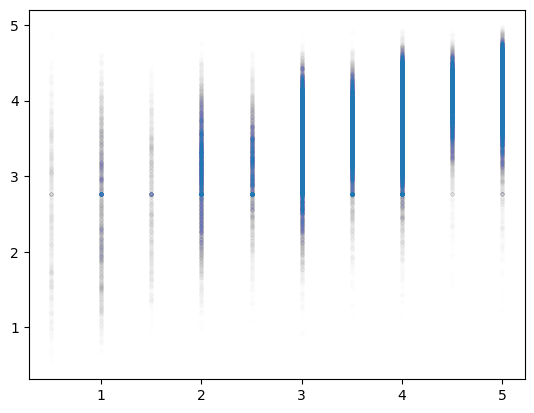

In [101]:
# 시각화 
plt.plot(y_val,net(X_val).data,'.',alpha=0.002)

-   전체적으로 우상향 $\to$ 그럭저럭 잘맞춤

`(2)` 아래는 유저 2303번에 대한 정보이다.

In [ ]:
df_train.query("userId == 2303")

유저 2303는 스릴러를 좋아하는 것 같다. 영화 {49:
`Usual Suspects, The (1995)`} 는 스리럴중에서도 인기가 있는 영화인데,
유저 2303는 아직 이 영화를 시청하지 않은듯 보인다.

In [ ]:
df_train.query("'Usual Suspects, The (1995)' in title")

유저 2303에게 이 영화를 추천하면 어떠한 평점을 줄까? (1)에서 학습한
네트워크로 예측하여 보라.

(풀이)

In [102]:
xx = torch.tensor([[2303, 49]])

print(f"예측된 유저 2303의 평점 : {net(xx).data.item():.4f}")

예측된 유저 2303의 평점 : 4.4371


# 2. `hello`

아래와 같이 hello가 반복되는 자료가 있다고 하자.

In [103]:
txt = list('hello')*100
txt[:10]

['h', 'e', 'l', 'l', 'o', 'h', 'e', 'l', 'l', 'o']

`(1)` `torch.nn.RNN()`을 이용하여 다음문자를 예측하는 신경망을 설계하고
학습하라.

(풀이)

In [104]:
## 데이터 정리
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
x = torch.tensor(df_train.x.map({'h':0, 'e':1, 'l':2, 'o':3}))
y = torch.tensor(df_train.y.map({'h':0, 'e':1, 'l':2, 'o':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [105]:
X.shape, y.shape

(torch.Size([499, 4]), torch.Size([499, 4]))

In [106]:
rnn = torch.nn.RNN(4, 2)
cook = torch.nn.Linear(2, 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr = 0.1)

for epoc in range(200) :
    h, hL = rnn(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

In [107]:
h, _ = rnn(X)
yhat = torch.nn.functional.softmax(cook(h), dim = 1)

yhat

tensor([[2.4680e-08, 9.9686e-01, 1.0288e-03, 2.1104e-03],
        [9.3238e-06, 4.8199e-05, 9.9994e-01, 5.8198e-07],
        [3.7407e-03, 3.1529e-04, 9.9546e-01, 4.8665e-04],
        ...,
        [9.3403e-06, 4.8200e-05, 9.9994e-01, 5.8288e-07],
        [3.7490e-03, 3.1595e-04, 9.9545e-01, 4.8844e-04],
        [1.2690e-03, 2.6101e-03, 6.8105e-05, 9.9605e-01]],
       grad_fn=<SoftmaxBackward0>)

`(2)` `torch.nn.RNNCell()`을 이용하여 다음문자를 예측하는 신경망을
설계하고 학습하라.

(풀이)

In [156]:
torch.manual_seed(42)
rnncell = torch.nn.RNNCell(4, 2)
cook = torch.nn.Linear(2, 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters()) + list(cook.parameters()), lr = 0.1)

#---#
L = len(X)
for epoc in range(200) :
    loss = 0
    ht = torch.zeros(2) ## h0

    for t in range(L) :
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht)
        loss = loss_fn(ot, yt) + loss

    loss = loss/L
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

In [157]:
h = torch.zeros(L, 2)
h0 = torch.zeros(2)
h[0] = rnncell(X[0], h0)

for t in range(1, L) :
    h[t] = rnncell(X[t], h[t-1])

yhat = torch.nn.functional.softmax(cook(h), dim = 1)

yhat

tensor([[9.7411e-04, 9.9320e-01, 5.8257e-03, 7.2051e-07],
        [4.2004e-06, 2.2732e-03, 9.9758e-01, 1.4352e-04],
        [1.1946e-05, 3.4355e-04, 9.9618e-01, 3.4675e-03],
        ...,
        [4.4366e-06, 2.4122e-03, 9.9744e-01, 1.4318e-04],
        [1.0508e-05, 3.4238e-04, 9.9663e-01, 3.0165e-03],
        [1.3928e-03, 1.4144e-06, 2.9802e-03, 9.9563e-01]],
       grad_fn=<SoftmaxBackward0>)

`(3)` `(2)`의 결과와 동일한 적합값을 출력하는 신경망을 직접설계한뒤
학습시켜라. (초기값을 적절하게 설정할 것)

``` python
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = ????
        self.h2h = ????
        self.tanh = ????
    def forward(self,??,??):
        ht = ????
        return ht
```

위의 클래스의 `????`를 채워 (2)의 결과와 동일한 적합값이 나오도록 하라.

-   class를 이용하지 않으면 점수없음.
-   `torch.nn.RNN()`, `torch.nn.RNNCell()` 을 이용한 네트워크를
    학습시킬시 점수 없음. (초기값을 셋팅하는 용도로는 torch.nn.RNN(),
    torch.nn.RNNCell()을 코드에 포함시키는 것이 가능)

(풀이)

In [163]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4, 2)
        self.h2h = torch.nn.Linear(2, 2)
        self.tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = self.tanh(self.i2h(Xt) + self.h2h(ht))
        return ht

## 시드를 먹일 땐, 선언하는 순서도 똑같이 해줘야 같은 값이 할당됨...
torch.manual_seed(42)
rnncell = torch.nn.RNNCell(4, 2)
cook = torch.nn.Linear(2, 4)
rnncell2 = rNNCell()

## parameter overwriting
rnncell2.i2h.weight.data = rnncell.weight_ih.data
rnncell2.h2h.weight.data = rnncell.weight_hh.data
rnncell2.i2h.bias.data = rnncell.bias_ih.data
rnncell2.h2h.bias.data = rnncell.bias_hh.data

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell2.parameters()) + list(cook.parameters()), lr = 0.1)

#---#
L = len(X)
for epoc in range(200) :
    loss = 0
    ht = torch.zeros(2) ## h0

    for t in range(L) :
        Xt, yt = X[t], y[t]
        ht = rnncell2(Xt, ht)
        ot = cook(ht)
        loss = loss_fn(ot, yt) + loss

    loss = loss/L
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

In [164]:
h = torch.zeros(L, 2)
h0 = torch.zeros(2)
h[0] = rnncell2(X[0], h0)

for t in range(1, L) :
    h[t] = rnncell2(X[t], h[t-1])

yhat = torch.nn.functional.softmax(cook(h), dim = 1)

yhat

tensor([[9.7411e-04, 9.9320e-01, 5.8257e-03, 7.2051e-07],
        [4.2004e-06, 2.2732e-03, 9.9758e-01, 1.4352e-04],
        [1.1946e-05, 3.4355e-04, 9.9618e-01, 3.4675e-03],
        ...,
        [4.4366e-06, 2.4122e-03, 9.9744e-01, 1.4318e-04],
        [1.0508e-05, 3.4238e-04, 9.9663e-01, 3.0165e-03],
        [1.3928e-03, 1.4144e-06, 2.9802e-03, 9.9563e-01]],
       grad_fn=<SoftmaxBackward0>)

> (2)번과 동일한 결과를 산출하는 것을 알 수 있다.

# 3. `Human_Numbers`

`HUMAN_NUMBERS_train.txt` 사람이 읽을 수 있는 형식으로 숫자가 나열된
텍스트 파일이다. 이 텍스트 파일을 이용하여 “현재 단어가 주어졌을 때 다음
단어를 예측하는” 신경망을 설계하고 학습시킬 것이다. 아래는 해당 파일을
불러와 단어 단위로 나눈 결과를 확인하는 코드이다.

In [5]:
with open('HUMAN_NUMBERS_train.txt') as f:
    words = f.read().split()
print(words[-12:])

['seven', 'thousand', 'nine', 'hundred', 'ninety', 'eight', 'seven', 'thousand', 'nine', 'hundred', 'ninety', 'nine']


이 텍스트 파일에는 예를 들어 “… seven, thousand, nine, hundred, ninety,
eight, …” 등과 같은 사람이 읽는 숫자 표현이 단어 단위로 나열된 시퀀스
형태로 저장되어 있다.

이러한 데이터에서 “현재 단어가 주어졌을 때 다음 단어를 예측하는” 자연어
처리 모델을 학습하라. 즉 아래와 같은 맵핑을 학습하라.

-   … seven, thousand, nine, hundred, ninety, eight $\to$ seven
-   … seven, thousand, nine, hundred, ninety, eight, seven $\to$
    thousand
-   … seven, thousand, nine, hundred, ninety, eight, seven, thousand
    $\to$ nine

**제약사항**

-   one-hot 전처리 코드를 포함할 것
-   `torch.nn.RNN`, `torch.nn.RNNCell`, `torch.nn.LSTM` 중 하나를 이용할
    것
-   처음 12개의 단어와 마지막 12개의 단어에 대한 적합값(fitted value)을
    제시할 것

`(풀이)`

In [95]:
with open('HUMAN_NUMBERS_train.txt') as f:
    words = f.read().split()
words[:10]
df_train = pd.DataFrame({'x': words[:-1], 'y': words[1:]})

# 전체 vocab 기준으로 맵핑
vocab = sorted(set(words))
dct= {w: i for i, w in enumerate(vocab)}
# train 데이터셋
x = torch.tensor(df_train.x.map(dct))
y = torch.tensor(df_train.y.map(dct))

In [96]:
# one-hot 전처리
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [150]:
lstm = torch.nn.LSTM(29, 16)
cook = torch.nn.Sequential(
    torch.nn.Linear(16, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 29)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(cook.parameters()), lr = 0.008)

#---#
for epoc in range(1, 1501) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 100	train acc = 0.4468
epoch : 200	train acc = 0.7561
epoch : 300	train acc = 0.8757
epoch : 400	train acc = 0.9087
epoch : 500	train acc = 0.9695
epoch : 600	train acc = 0.9813
epoch : 700	train acc = 0.9889
epoch : 800	train acc = 0.9935
epoch : 900	train acc = 0.9957
epoch : 1000	train acc = 0.9968
epoch : 1100	train acc = 0.9977
epoch : 1200	train acc = 0.9981
epoch : 1300	train acc = 0.9985
epoch : 1400	train acc = 0.9989
epoch : 1500	train acc = 0.9991


In [151]:
#---#
for epoc in range(1501, 2001) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 1600	train acc = 0.9994
epoch : 1700	train acc = 0.4070
epoch : 1800	train acc = 0.6873
epoch : 1900	train acc = 0.8500
epoch : 2000	train acc = 0.9181


In [152]:
#---#
for epoc in range(2001, 3001) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 2100	train acc = 0.9487
epoch : 2200	train acc = 0.9663
epoch : 2300	train acc = 0.9755
epoch : 2400	train acc = 0.9815
epoch : 2500	train acc = 0.9858
epoch : 2600	train acc = 0.9889
epoch : 2700	train acc = 0.9910
epoch : 2800	train acc = 0.9933
epoch : 2900	train acc = 0.9943
epoch : 3000	train acc = 0.9955


In [155]:
#---#
for epoc in range(3001, 4001) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 3100	train acc = 0.9966
epoch : 3200	train acc = 0.9972
epoch : 3300	train acc = 0.9975
epoch : 3400	train acc = 0.9980
epoch : 3500	train acc = 0.9983
epoch : 3600	train acc = 0.9985
epoch : 3700	train acc = 0.9986
epoch : 3800	train acc = 0.9988
epoch : 3900	train acc = 0.9989
epoch : 4000	train acc = 0.9990


In [156]:
#---#
for epoc in range(4001, 5001) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 4100	train acc = 0.9991
epoch : 4200	train acc = 0.9992
epoch : 4300	train acc = 0.9993
epoch : 4400	train acc = 0.9995
epoch : 4500	train acc = 0.9995
epoch : 4600	train acc = 0.4686
epoch : 4700	train acc = 0.6334
epoch : 4800	train acc = 0.7464
epoch : 4900	train acc = 0.8101
epoch : 5000	train acc = 0.8526


In [159]:
#---#
for epoc in range(5001, 6001) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 5100	train acc = 0.8890
epoch : 5200	train acc = 0.9239
epoch : 5300	train acc = 0.9541
epoch : 5400	train acc = 0.9703
epoch : 5500	train acc = 0.9805
epoch : 5600	train acc = 0.9860
epoch : 5700	train acc = 0.9898
epoch : 5800	train acc = 0.9923
epoch : 5900	train acc = 0.9937
epoch : 6000	train acc = 0.9949


In [163]:
#---#
for epoc in range(6001, 7001) :
    h, _ = lstm(X)
    netout = cook(h)

    loss = loss_fn(netout, y)
    loss.backward()

    optimizr.step()
    optimizr.zero_grad()

    if epoc % 100 == 0 :
        h, _ = lstm(X)
        yhat = torch.nn.functional.softmax(cook(h), dim = 1)
        acc = (yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean().item()
        print(f"epoch : {epoc}\ttrain acc = {acc:.4f}")

epoch : 6100	train acc = 0.9957
epoch : 6200	train acc = 0.9963
epoch : 6300	train acc = 0.9968
epoch : 6400	train acc = 0.9974
epoch : 6500	train acc = 0.9981
epoch : 6600	train acc = 0.9985
epoch : 6700	train acc = 0.9988
epoch : 6800	train acc = 0.9990
epoch : 6900	train acc = 0.9992
epoch : 7000	train acc = 0.9993


In [200]:
loss

tensor(0.0066, grad_fn=<DivBackward1>)

> 어떻게 해요??? 언더피팅 나는데 -> 아담을 좀 손보면 어떻게 될듯? epsilon 값을 줄이면 진동 줄어듦
>
> 그리고 굳이 정제된 걸 DNN 먹여야 하나? -> 해야됨, 언더피팅남, 근데 0.7까진 올라가네...
>
> 진짜 근데 어떻게 함? 이거 개어렵네...
>
> 다 맞출 필요 없음, 이미 700 에폭 쯤에서 오버피팅 났을 수도 있다고 하심 -> 바꿀 것
>
> 적합값은 인덱스만 추출해도 됨. ㅇㅇ

In [201]:
h, _ = lstm(X)
yhat = torch.nn.functional.softmax(cook(h), dim = 1)

In [202]:
(yhat.argmax(axis = 1) == y.argmax(axis = 1)).float().mean() ## LSTM 1000 epochs

tensor(0.9993)

In [205]:
inv_dct = {v:k for k, v in dct.items()}

print(
    f"처음 12개 단어 적합값 : {[inv_dct[t.item()] for t in yhat.argmax(axis = 1)[:12]]}\n",
    f"마지막 12개 단어 적합값 : {[inv_dct[t.item()] for t in yhat.argmax(axis = 1)[-12:]]}"
)

처음 12개 단어 적합값 : ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen']
 마지막 12개 단어 적합값 : ['seven', 'thousand', 'nine', 'hundred', 'ninety', 'eight', 'seven', 'thousand', 'nine', 'hundred', 'ninety', 'nine']


# 4. `FrozenLake`

ref: <https://www.gymlibrary.dev/environments/toy_text/frozen_lake/>

아래는 OpenAI Gym 라이브러리에서 제공하는 환경 Frozen Lake를 구체화하여
변수 `env`에 저장하는 코드이다.

In [4]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array')

Frozen Lake 환경은 강화학습(RL) 실험을 위한 간단한 시뮬레이션 환경으로
에이전트가 얼어붙은 호수 위를 안전하게 건너 목표 지점에 도달하는 것이
목표이다. 주요 특징은 다음과 같다.

`1`. **환경 구성**:

-   격자형(grid) 환경으로 이루어져 있으며, 각 격자는 4x4 또는 8x8의
    형태를 가질 수 있다. (문제에서는 4x4)
-   격자는 시작 지점(Start), 목표 지점(Goal), 얼음(Ice), 그리고
    구멍(Hole)으로 구성된다.
-   에이전트는 시작 지점에서 목표 지점까지 이동해야 한다.

`2`. **에이전트의 동작**:

-   에이전트는 상, 하, 좌, 우로 이동할 수 있다.
-   얼음 위에서는 자유롭게 이동할 수 있지만, 구멍에 빠지면 에피소드가
    종료된다.

`3`. **보상 체계**:

-   에이전트가 목표 지점에 도달하면 +1의 보상을 받는다.
-   그 외에는 보상이 없다(0 보상).
-   구멍에 빠지거나 목표 지점에 도달하지 못하면 보상은 없다.

`4`. **목표**:

-   에이전트는 강화학습 알고리즘을 사용하여 최적의 경로를 학습하고,
    가능한 한 구멍에 빠지지 않고 목표 지점에 도달하는 것이다.

아래는 `show` 함수이며, 이는 `env`의 현재상태를 렌더링해주는 역할을
한다.

In [5]:
def show(ims):
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(ims[i])
    ani = FuncAnimation(fig,update,frames=len(ims))
    display(IPython.display.HTML(ani.to_jshtml()))

`show()` 함수의 사용방법은 아래와 같다.

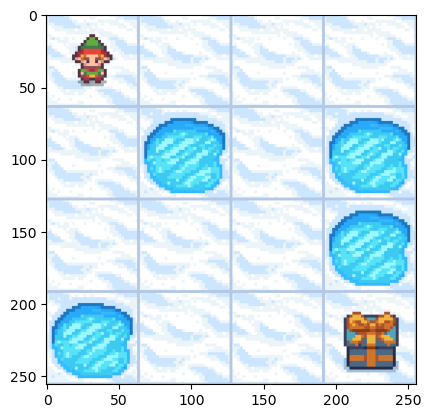

In [7]:
env.reset()
plt.imshow(env.render());

적당한 위의 환경에 대응하는 Agent를 설계하고 `q_net`를 이용하여 올바른
행동을 학습하라.

(풀이)

In [17]:
class RandomAgent:
    def __init__(self):
        #--# define spaces 
        self.action_space = gym.spaces.Discrete(4)
        #--# replay buffer 
        self.current_state =  None   
        self.action = None           
        self.reward = None           
        self.next_state = None      
        self.terminated = None
        #-#
        self.current_states = collections.deque(maxlen=50000)
        self.actions = collections.deque(maxlen=50000)
        self.rewards = collections.deque(maxlen=50000)
        self.next_states = collections.deque(maxlen=50000)
        self.terminations = collections.deque(maxlen=50000)
        #--# other information 
        self.n_experiences = 0
    def act(self):
        self.action = self.action_space.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.current_states.append(torch.tensor(self.current_state))
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(self.terminated)
        #--#
        self.n_experiences = self.n_experiences + 1


class Agent(RandomAgent) :
    def __init__(self) :
        super().__init__()

        self.eps = 1.0
        self.q_net = torch.nn.Sequential(
            torch.nn.Embedding(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 4)
        )
        self.optimizr = torch.optim.Adam(self.q_net.parameters())

    def act(self) :
        if random.random() < self.eps :
            self.action = self.action_space.sample()
        else :
            self.action = self.q_net(torch.tensor(self.current_state)).argmax().item()

    def learn(self) :
        if self.n_experiences > 64:
            for epoc in range(1):
                memory = list(zip(self.current_states, self.actions, self.rewards, self.next_states, self.terminations))
                mini_batch = random.sample(memory,64)

                loss = 0
                
                for s,a,r,ss,tmd in mini_batch:
                    q_hat = self.q_net(s)[a]
                    if tmd:
                        q = r
                    else: 
                        future = self.q_net(ss).max().data 
                        q = r + 0.99 * future ## discount rate
                    loss = loss + (q_hat-q)**2
                    
                loss = loss / 64
                loss.backward()
                
                self.optimizr.step()
                self.optimizr.zero_grad()   

In [18]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array')
player = Agent()
player.current_state, _ = env.reset()
score = 0
playtime = 0
scores = [] 
playtimes = []

#---#
print(f"----------학습 시작 : {datetime.datetime.now()}----------")

for e in range(1,2001):
    #---에피소드시작---#
    while True:
        #step1 : Action
        player.act()
        #step2 : Environment
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        playtime += 1 ## 이동 횟수 기록
        #step3
        player.save_experience()
        player.learn()
        #step4
        score += player.reward
        
        if player.terminated or player.truncated:
            scores.append(score)
            score = 0
            playtimes.append(playtime)
            playtime = 0
            player.current_state, _ = env.reset()
            break
        else:
            player.current_state = player.next_state
    #---에피소드끝---#
    player.eps = player.eps * 0.996 ## decay rate
    if (e % 100) ==0:
        print(
            f"에피소드: {e}\t",
            f"경험: {player.n_experiences}\t",
            f"점수(평균): {np.mean(scores[-100:]):.2f}\t",
            f"이동횟수(평균): {np.mean(playtimes[-100:]):.2f}\t",
            f"돌발행동: {player.eps:.2f}\t",
        )

    ## 최적의 루트로 도착했을 때 종료
    if np.mean(scores[-100:]) > 0.9 and np.mean(playtimes[-100:]) <= 6.5:
        print(
            f"----------학습 종료 : {datetime.datetime.now()}----------\n",
            f"<최종 집계>\n",
            f"총 에피소드: {e}\t",
            f"총 경험: {player.n_experiences}\t",
            f"점수(평균): {np.mean(scores[-100:]):.2f}\t",
            f"이동횟수(평균): {np.mean(playtimes[-100:]):.2f}\t"
        )
        break

----------학습 시작 : 2025-06-16 22:40:56.845652----------
에피소드: 100	 경험: 857	 점수(평균): 0.01	 이동횟수(평균): 8.57	 돌발행동: 0.67	
에피소드: 200	 경험: 2223	 점수(평균): 0.02	 이동횟수(평균): 13.66	 돌발행동: 0.45	
에피소드: 300	 경험: 3727	 점수(평균): 0.00	 이동횟수(평균): 15.04	 돌발행동: 0.30	
에피소드: 400	 경험: 5638	 점수(평균): 0.03	 이동횟수(평균): 19.11	 돌발행동: 0.20	
에피소드: 500	 경험: 8583	 점수(평균): 0.27	 이동횟수(평균): 29.45	 돌발행동: 0.13	
에피소드: 600	 경험: 12454	 점수(평균): 0.38	 이동횟수(평균): 38.71	 돌발행동: 0.09	
----------학습 종료 : 2025-06-16 22:45:26.456283----------
 <최종 집계>
 총 에피소드: 687	 총 경험: 13000	 점수(평균): 0.93	 이동횟수(평균): 6.43	


In [20]:
imgs = []

player.eps = 0
player.current_state, _ = env.reset()
imgs.append(env.render())

while True:
    player.act()
    player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
    imgs.append(env.render())
    if player.terminated or player.truncated:
        break
    else:
        player.current_state = player.next_state


show(imgs)

In [15]:
imgs = []

player.eps = 0
player.current_state, _ = env.reset()
imgs.append(env.render())

while True:
    player.act()
    player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
    imgs.append(env.render())
    if player.terminated or player.truncated:
        break
    else:
        player.current_state = player.next_state


show(imgs)

# 5. `4x4 GirdWorld`

아래의 제약조건에 맞추어 14wk-2의 Solve를 해결할 것

1.  **Q-테이블 초기화 및 사용 방식**: 에이전트는 `q_net`이 아닌
    `q_table`을 사용하여 업데이트하며, `q_table`은 np.random.randn(4, 4,
    4)로 초기화된다.
2.  **액션 선택 전략**: 매 스텝마다 일정 확률로 랜덤 액션을 수행하고,
    랜덤이 아닐 경우에는 q_table을 참고해 가장 높은 Q값을 갖는 최적의
    액션을 선택한다.
3.  **탐험 확률 감소 (ε-greedy)**: 랜덤액션을 선택하는 확률은 초기값
    100%에서 시작하여, 매 에피소드마다 “이전 확률 × 0.995” 방식으로 점차
    감소한다.
4.  **감가율 (Discount Factor)**: 미래 보상의 중요도를 반영하기 위한
    감가율은 0.95로 설정한다.
5.  **학습률 (Learning Rate)**: `q`와 `q_hat`의 차이를 얼마나 반영할지를
    결정하는 학습률은 0.01로 설정한다.
6.  **경험 메모리 구조**: 플레이어(=에이전트)는 최대 5000개의 경험을
    저장할 수 있다.
7.  **학습 조건 및 방식 (learn 함수)**: 저장된 경험이 64개 이상일 때만
    학습이 수행되며, 경험 메모리에서 64개를 무작위로 샘플링하여
    q_table을 업데이트한다.
8.  **종료 조건 (Success Criterion)**: 최근 10개 에피소드의 평균 score가
    90 이상이면 과업을 완료한 것으로 간주하고 학습을 종료한다.
9.  **플레이타임 계산**: 각 에피소드가 끝날 때까지 몇 번의 step이
    소요되었는지 기록하며, 이를 기반으로 에피소드별 플레이타임을
    저장한다.
10. **시각화 출력**: 최종학습결과를 13wk-2 주차 강의의 `show()` 함수를
    이용하여 시각화한다.

(풀이)

`-` 클래스 선언

In [217]:
class GridWorld :
    def __init__(self) :
        self.a2d = {
            0: np.array([0,1]),  # →
            1: np.array([0,-1]), # ←  
            2: np.array([1,0]),  # ↓
            3: np.array([-1,0])  # ↑
        }

        self.states_space = gym.spaces.MultiDiscrete([4, 4])
        self.state = np.array([0, 0])
        self.reward = None
        self.terminated = False

    def step(self, action) :
        self.state = self.state + self.a2d[action] ## 여기서 깊은복사 이슈 나는듯
        s1, s2 = self.state

        if (s1 == 3) and (s2 == 3) :
            self.reward = 100
            self.terminated = True
        
        elif self.state in self.states_space :
            self.reward = -1
            self.terminated = False

        else :
            self.reward = -10
            self.terminated = True

        return self.state, self.reward, self.terminated

    def reset(self) :
        self.state = np.array([0, 0])
        self.terminated = False
        
        return self.state

In [226]:
class RandomAgent:
    def __init__(self):
        self.state = np.array([0,0]) 
        self.action = None 
        self.reward = None 
        self.next_state = None
        self.terminated = None
        #---#
        self.states = collections.deque(maxlen=500000)
        self.actions = collections.deque(maxlen=500000)
        self.rewards = collections.deque(maxlen=500000)
        self.next_states = collections.deque(maxlen=500000)
        self.terminations = collections.deque(maxlen=500000)
        #---#
        self.action_space = gym.spaces.Discrete(4)
        self.n_experience = 0
        self.playtimes = []
    def act(self):
        self.action = self.action_space.sample()
    def save_experience(self):
        self.states.append(self.state)
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated)
        self.n_experience = self.n_experience + 1
    def learn(self):
        pass

In [229]:
class GreedyAgent :
    def __init__(self) :
        """
        q_table은 np.random.randn(4, 4, 4)로 초기화
        에이전트는 최대 5000개의 경험을 저장할 수 있음
        탐험 확률은 초기값 100%(1.0)에서 시작
        """
        #--# define spaces
        self.action_space = gym.spaces.Discrete(4)
        #--# replay buffer
        self.state =  None
        self.action = None
        self.reward = None
        self.next_state = None
        self.terminated = None
        #-#
        self.states = collections.deque(maxlen=5000)
        self.actions = collections.deque(maxlen=5000)
        self.rewards = collections.deque(maxlen=5000)
        self.next_states = collections.deque(maxlen=5000)
        self.terminations = collections.deque(maxlen=5000)
        #--# other information 
        self.n_experience = 0
        self.eps = 1.0 ## 초기값 100%에서 시작
        self.q_table = np.random.randn(4, 4, 4) ## q-table 초기화

    def act(self) :
        """
        매 스텝마다 일정 확률(eps)로 랜덤 액션, 아니면 q_table 참고 최적의 액션
        """
        if random.random() < self.eps :
            self.action = self.action_space.sample()
        else :
            s1, s2 = self.state
            self.action = self.q_table[s1, s2, :].argmax()

    def save_experience(self):
        self.states.append(self.state)
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated)
        #--#
        self.n_experience = self.n_experience + 1

    def learn(self) :
        """
        저장된 경험(n_experience)이 64개 이상일 때만 q_table 업데이트
        감가율은 0.95, 학습률은 0.01로 설정
        """
        if self.n_experience >= 64:
            memory = list(zip(self.states, self.actions, self.rewards, self.next_states, self.terminations))
            mini_batch = random.sample(memory,64)
            
            for (s1, s2), a, r, (ss1, ss2), tmd in mini_batch:
                q_hat = self.q_table[s1, s2, a]

                if tmd:
                    q = r
                else: 
                    future = self.q_table[ss1, ss2, :].max()
                    q = r + 0.95 * future ## discount rate 0.95

                diff = q - q_hat
                self.q_table[s1, s2, a] += 0.01 * diff ## learning rate 0.01

`-` 학습

In [240]:
env = GridWorld()
player = GreedyAgent()
player.state = env.reset()

score = 0 ## score 기록
playtime = 0 ## step 기록
scores = [] ## 에피소드별 점수 저장 -> 종료 조건
playtimes = [] ## 에피소드별 플레이타임 저장

#---#
for e in range(1,1001):
    #---에피소드시작---#
    while True:
        #step1 : Action
        player.act()
        #step2 : Environment
        player.next_state, player.reward, player.terminated = env.step(player.action)
        playtime += 1 ## step 소요 기록
        #step3 : Save & Learn
        player.save_experience()
        player.learn()
        #step4 : Exit
        score += player.reward
        
        if player.terminated :
            scores.append(score)
            score = 0
            playtimes.append(playtime)
            playtime = 0
            player.state = env.reset()
            break
        else: 
            player.state = player.next_state
    #---에피소드끝---#
    player.eps = player.eps * 0.995 ## decay rate 0.995
    
    if (e % 100) == 0:
        print(
            f"에피소드: {e}\t",
            f"경험: {player.n_experience}\t",
            f"점수(평균): {np.mean(scores[-10:]):.2f}\t",
            f"이동횟수(평균): {np.mean(playtimes[-10:]):.2f}\t",
            f"돌발행동: {player.eps:.2f}\t",
        )

    ## 최근 10개 에피소드의 평균 score가 90 이상이면 학습 종료
    if np.mean(scores[-10:]) > 90 :
        print(
            f"--------------------학습 종료--------------------\n",
            f"<최종 집계>\n",
            f"총 에피소드: {e}\t",
            f"총 경험: {player.n_experience}\t",
            f"점수(평균): {np.mean(scores[-10:]):.2f}\t",
            f"이동횟수(평균): {np.mean(playtimes[-10:]):.2f}\t"
        )
        break

에피소드: 100	 경험: 482	 점수(평균): -13.40	 이동횟수(평균): 4.40	 돌발행동: 0.61	
에피소드: 200	 경험: 1102	 점수(평균): 69.10	 이동횟수(평균): 9.90	 돌발행동: 0.37	
에피소드: 300	 경험: 1755	 점수(평균): 52.00	 이동횟수(평균): 5.00	 돌발행동: 0.22	
--------------------학습 종료--------------------
 <최종 집계>
 총 에피소드: 350	 총 경험: 2078	 점수(평균): 93.20	 이동횟수(평균): 7.80	


`-` 최종 결과 시각화

In [241]:
def show(states):
    fig = plt.Figure()
    ax = fig.subplots()
    ax.matshow(np.zeros([4,4]), cmap='bwr',alpha=0.0)
    sc = ax.scatter(0, 0, color='red', s=500)  
    ax.text(0, 0, 'start', ha='center', va='center')
    ax.text(3, 3, 'end', ha='center', va='center')
    # Adding grid lines to the plot
    ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 4, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    state_space = gym.spaces.MultiDiscrete([4,4])
    def update(t):
        if states[t] in state_space:
            s1,s2 = states[t]
            states[t] = [s2,s1]
            sc.set_offsets(states[t])
        else:
            s1,s2 = states[t]
            s1 = s1 + 0.5 if s1 < 0 else (s1 - 0.5 if s1 > 3 else s1)
            s2 = s2 + 0.5 if s2 < 0 else (s2 - 0.5 if s2 > 3 else s2)
            states[t] = [s2,s1]       
            sc.set_offsets(states[t])
    ani = FuncAnimation(fig,update,frames=len(states))
    display(IPython.display.HTML(ani.to_jshtml()))

In [242]:
player.eps = 0
player.state = env.reset()
states = [np.array([0, 0])]

while True :
    player.act()
    player.next_state, player.reward, player.terminated = env.step(player.action)
    states.append(player.next_state)

    if player.terminated :
        break

    else :
        player.state = player.next_state

In [243]:
np.stack(states, axis = 1)
show(states)

# 6. 미공개 문제